# The Laplace Problem

In [35]:
%reset -f

In [36]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

import numpy as np
import jax
import jax.numpy as jnp
from jax.tree_util import Partial
jax.config.update('jax_platform_name', 'cpu')           ## CPU is faster here !
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='ticks',
        font='sans-serif', font_scale=1, color_codes=True, rc={"lines.linewidth": 2})
# import cmasher as cmr
plt.style.use("dark_background")

from updec import *
# from updec.operators import *
# from updec.utils import print_line_by_line, polyharmonic, multiquadric

key = jax.random.PRNGKey(42)


## Using Updec

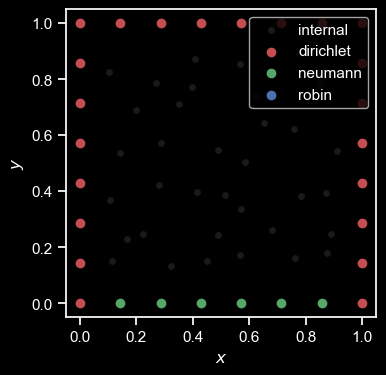

In [37]:
facet_types={"south":"n", "west":"d", "north":"d", "east":"d"}
size = 8
cloud = SquareCloud(Nx=size, Ny=size, facet_types=facet_types, noise_key=key, support_size=size*size-1)

# h = cloud.average_spacing()
# alpha = (cloud.N)**(-0.25)

# RBF = Partial(gaussian, eps=2e-0)      ## Can define which rbf to use
RBF = polyharmonic
MAX_DEGREE = 4

# facet_types = {"Dirichlet":"d"}
# cloud = GmshCloud("./meshes/disk.msh", facet_types, support_size=20)

cloud.visualize_cloud(figsize=(4,4), cmap="cmr.amber");

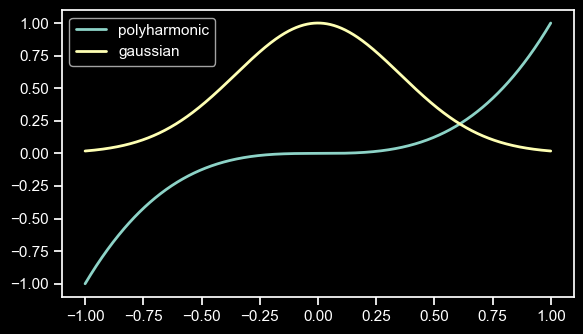

In [38]:
# print(alpha, h)
x=jnp.linspace(-1,1,1000)
y = polyharmonic(x)
z = gaussian(x, eps=2)

ax = plot(x,y, label="polyharmonic")
ax = plot(x,z, label="gaussian", ax=ax)

In [39]:
print("\n=== Meshfree cloud for RBF method ===\n")
print()
print("Cloud bounding box: Nx =", cloud.Nx, " -  Ny =", cloud.Ny)
print()
# print("Boundary types (0=internal, 1=dirichlet, 2=neumann):\n", cloud.node_boundary_types)
print("Number of: \n\t-Internal points: Ni =", cloud.Ni, "\n\t-Dirichlet points: Md =", cloud.Nd, "\n\t-Neumann points: Mn =", cloud.Nn)
print("Surface types:\n", cloud.facet_types)
print()
print("Global indices:\n", cloud.global_indices)
print()
# # print("Global indices reversed:\n", cloud.global_indices_rev)
# # print()
print("Outward normals on Neumann/Robin boundaries:")
print_line_by_line(cloud.outward_normals)
# print()
# print("Node coordinates:", )
# print_line_by_line(cloud.nodes)
# print()
# print("Local supports (closest neighbours):")
# print_line_by_line(cloud.local_supports)


=== Meshfree cloud for RBF method ===


Cloud bounding box: Nx = 8  -  Ny = 8

Number of: 
	-Internal points: Ni = 36 
	-Dirichlet points: Md = 22 
	-Neumann points: Mn = 6
Surface types:
 {'south': 'n', 'west': 'd', 'north': 'd', 'east': 'd'}

Global indices:
 [[36 37 38 39 40 41 42 43]
 [58  0  1  2  3  4  5 44]
 [59  6  7  8  9 10 11 45]
 [60 12 13 14 15 16 17 46]
 [61 18 19 20 21 22 23 47]
 [62 24 25 26 27 28 29 48]
 [63 30 31 32 33 34 35 49]
 [50 51 52 53 54 55 56 57]]

Outward normals on Neumann/Robin boundaries:
	 58 : [ 0. -1.]
	 59 : [ 0. -1.]
	 60 : [ 0. -1.]
	 61 : [ 0. -1.]
	 62 : [ 0. -1.]
	 63 : [ 0. -1.]


In [40]:
## Operates on radial basis functions and polynomials at position x: don't forget the None. It is important!
# @jax.jit
# @partial(jax.jit, static_argnums=2)
def my_diff_operator(x, node=None, monomial=None, *args):
    return  nodal_laplacian(x, node, monomial, rbf=RBF)

# known_field = jnp.ones((cloud.N, ))

## Operates on entire fields at position x (inside node)
# @jax.jit
def my_rhs_operator(x):
    # return divergence(x, known_field, cloud, rbf=RBF, max_degree=2)
    # return -100.0
    return 0.0

d_north = lambda node: jnp.sin(jnp.pi * node[0])
# d_north2 = lambda node: 0.0
d_zero = lambda node: 0.0

boundary_conditions = {"south":d_zero, "west":d_zero, "north":d_north, "east":d_zero}

In [41]:
solution_field = pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE)
# unknown_field

/Users/roussel/miniforge3/envs/jaxenv/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [42]:
# ## Load JadeHPC solution
# cloud_shape = str(cloud.Nx)+"x"+str(cloud.Ny)
# solution_field = jnp.load("./temp/sol_laplace_"+cloud_shape+".npy")
# error = jnp.load("./temp/mse_error_laplace_"+cloud_shape+".npy")

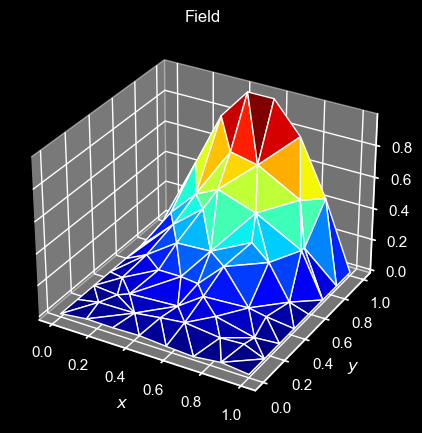

In [43]:
cloud.visualize_field(solution_field, cmap="jet", projection="3d", ax=None, figsize=(6,5));
# cloud.visualize_field(solution_field, cmap="viridis", projection="2d", ax=None, figsize=(6,5));

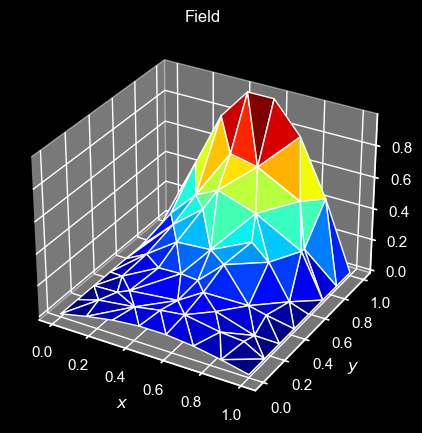

In [44]:
## Exact solution
coords = cloud.sort_nodes_jnp()

# exact_sol = jnp.zeros((cloud.N), dtype=jnp.float64)
def laplace_exact_sol(coord):
    # return jnp.cos(jnp.pi*coord[0])*jnp.sinh(jnp.pi*coord[1])
    # return 1 - (coord[0]**2 + coord[1]**2) / 4.     ## TODO Poisson a disk
    # return jnp.sin(jnp.pi*coord[0])*jnp.sinh(jnp.pi*coord[1]) / jnp.sinh(jnp.pi)
    return jnp.sin(jnp.pi*coord[0])*jnp.cosh(jnp.pi*coord[1]) / jnp.cosh(jnp.pi)

laplace_exact_sol = jax.vmap(laplace_exact_sol, in_axes=(0,), out_axes=0)

exact_sol = laplace_exact_sol(coords)

cloud.visualize_field(exact_sol, cmap="jet", projection="3d", ax=None, figsize=(6,5));
# ax, img = cloud.visualize_field(exact_sol, cmap="viridis", projection="2d", ax=None, figsize=(6,5), levels=50);

Error: 0.032658801557147114


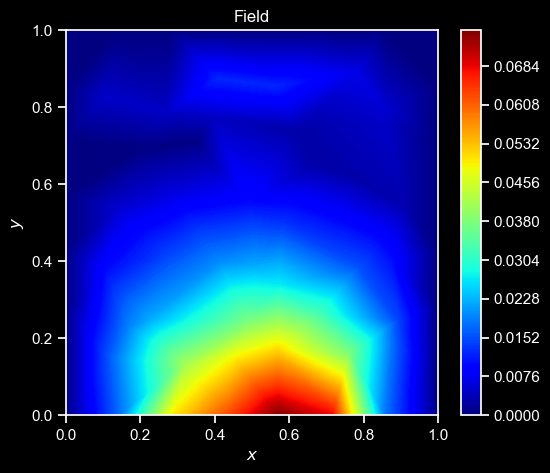

In [45]:
error = jnp.abs(exact_sol-solution_field)
print("Error:", jnp.sum(error**2))
# cloud.visualize_field(error, cmap="jet", projection="3d", ax=None, figsize=(10,10));
cloud.visualize_field(error, cmap="jet", projection="2d", ax=None, figsize=(6,5), levels=400);

In [46]:
# errors = []
# sizes = [4, 5, 7, 10, 12]
# for size in sizes:
#     cloud = SquareCloud(Nx=size, Ny=size, facet_types=facet_types, noise_key=key, support_size=size*size-1)
#     solution_field = pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE)

#     coords = cloud.sort_nodes_jnp()
#     exact_sol = laplace_exact_sol(coords)

#     error = jnp.mean(jnp.abs(exact_sol-solution_field)**2)
#     print(f"Size: {size} \t Error: {error}")
#     errors.append(error)

In [47]:
# ax = plot(sizes, errors, "o-")
# ax.set_xscale('log')
# ax.set_yscale('log')

## Code profiling

In [48]:
# ### Profiling the code
# import cProfile
# cloud = Cloud(Nx=11, Ny=7, facet_types=facet_types, noise_seed=34)
# cProfile.run('pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE)', filename=None, sort=2)